In [ ]:
# !pip install keras
# !pip install tensorflow==2.3.0

In [1]:
 !pip install --upgrade tensorflow_hub

Requirement already up-to-date: tensorflow_hub in c:\kyoungpark\lib\site-packages (0.9.0)


In [3]:
##코랩실행시 google driver mount 하기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#from google.colab import drive
#drive.mount('/content/drive')
#% cd /content/drive/My Drive/FAS
# % cd benchmark_liver_tumor/raw

In [4]:
# import tensorflow as tf
# tf.debugging.set_log_device_placement(False)
# # 텐서 생성
# a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
# b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
# c = tf.matmul(a, b)

# print(c)

In [5]:
! pip install pydicom

In [8]:
import pydicom as pdc
import matplotlib.pyplot as plt
from IPython.display import display, Image
import numpy as np
import cv2
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout
import tensorflow_hub as hub
%pylab inline
import glob
from PIL import Image

Populating the interactive namespace from numpy and matplotlib


In [9]:
pwd

'C:\\KyoungPark\\Project\\Code'

In [13]:
path = 'metadata/'
# Load Meta-data and preprocessing
patient_meta = pd.read_csv(path + 'patient_meta.csv')
patient_meta = patient_meta[['RANDOM_PT_NO','SEX','AGE','PHASE',"DX"]]
#patient_meta.head()

#NET, Lymphoma : Dropped (3 cases)
print("Drop:", patient_meta[(patient_meta['DX']=='lymphoma') | (patient_meta['DX']=='NET')].index)
patient_meta = patient_meta.drop(patient_meta[(patient_meta['DX']=='lymphoma') | (patient_meta['DX']=='NET')].index, axis=0)
patient_meta.reset_index(drop=True, inplace=True)

# categorical Variables(Sex, Phase)
# pd.get_dummies() 가변수 만들기
patient_meta = pd.concat([patient_meta, pd.get_dummies(patient_meta[['SEX','PHASE']])], axis=1)
patient_meta = patient_meta.drop(['SEX','PHASE'], axis=1)

# Continuous Variables(Age)
age = patient_meta['AGE'].values
age_scaled = preprocessing.scale(age)
 
patient_meta['AGE_NORM'] = age_scaled
patient_meta = patient_meta.drop(['AGE'], axis = 1)

#Label Setting
# 0 : Metastasis, 56
# 1 : Hepatocelluar Carcinoma, 30
# 2 : cholangiocarcinoma, 14 --> ????    # 숫자가 의미하는 것은??
for r in range(patient_meta.shape[0]):
    if('metastasis' in patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 0
    elif('HCC' == patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 1
    elif('cholangiocarcinoma' == patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 2
    else:
        patient_meta.iloc[r, 1] = -1

patient_meta = np.array(patient_meta)   #넘파이 배열로 변환

Drop: Int64Index([42, 66, 69], dtype='int64')


In [14]:
label_df = pd.read_csv('metadata/label_df.csv')
label_df.head()

,patient_no,img_idx,mean_annotation,DX
0,SN00017916,1,0.0,0
1,SN00017916,2,0.0,0
2,SN00017916,3,0.0,0
3,SN00017916,4,0.0,0
4,SN00017916,5,0.0,0


In [15]:
# 1 patient 당 DX list 가져오기
grouped_df=label_df.groupby('patient_no').agg(list)
temp_list=grouped_df.loc['SN00017916','DX']

In [16]:
#  sorted(glob.glob('./benchmark_liver_tumor/raw/'+'SN00017916'+'/*.dcm'))
pdc.dcmread('./benchmark_liver_tumor/raw/SN00017916/SN00017916_0020.dcm').pixel_array.shape

(512, 512)

In [17]:
print(f"한개의 dcm 이미지가 세로, 가로 각각 {512/32}개로 나뉘어져 총 {(512/32)**2}개의 pixel로 나눠져야함" )

한개의 dcm 이미지가 세로, 가로 각각 16.0개로 나뉘어져 총 256.0개의 pixel로 나눠져야함


In [18]:
path = 'metadata/'
# Load Meta-data and preprocessing
patient_dx = pd.read_csv(path + 'patient_meta.csv')
patient_dx = patient_dx[['RANDOM_PT_NO','SEX','AGE','PHASE',"DX"]]
#patient_meta.head()

#NET, Lymphoma : Dropped (3 cases)
print("Drop:", patient_dx[(patient_dx['DX']=='lymphoma') | (patient_dx['DX']=='NET')].index)
patient_dx = patient_dx.drop(patient_dx[(patient_dx['DX']=='lymphoma') | (patient_dx['DX']=='NET')].index, axis=0)
patient_dx.reset_index(drop=True, inplace=True)

def find_disease(patient_no):
    dx=np.array(patient_dx[patient_dx['RANDOM_PT_NO'] == patient_no]['DX'])[0]
    if 'metastasis'in dx:
        return 0
    elif dx == 'HCC':
        return 1
    elif dx == 'cholangiocarcinoma':
        return 2
    else:
        return 3

Drop: Int64Index([42, 66, 69], dtype='int64')


In [19]:
# 1 patient 당 DX list 가져오기
# sliding-window Proprocessing (길이가 다른 z 축데이터를 동일하게 만들어준다.)
window_size = 5
# size = (32,32) #resize는 안하기 때문
n_ct_statistics=[]
# 10-cv Settings
kf = KFold(n_splits=5, random_state=None, shuffle=True)
for tr_list, te_list in kf.split(patient_meta):
    # Train Dataset
    X_p_tr, X_m_tr, X_i_tr, Y_tr = [], [], [], []
    for tr_idx in tr_list:
        patient_no = patient_meta[tr_idx, 0]
        X_i_tr_ct_list =  sorted(glob.glob('./benchmark_liver_tumor/raw/'+patient_no+'/*.dcm'))
        Y_i_tr_label_list =  sorted(glob.glob('./benchmark_liver_tumor/raw/'+patient_no+'/label/*.png'))
        assert len(X_i_tr_ct_list) == len(Y_i_tr_label_list), "CT 랑 label 갯수가 다릅니다."
        n_ct = len(X_i_tr_ct_list)
        # Load 3D CT Data per Patient
        ct_block = [] #사진
        label_block = [] # annotation label
        for z in range(n_ct):
            # ct_block.append(cv2.resize(cv2.normalize(exposure.equalize_adapthist(pdc.dcmread(X_i_tr_ct_list[z]).pixel_array, clip_limit=0.03, nbins=512), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F), dsize=size))
            ct_block.append(cv2.normalize(pdc.dcmread(X_i_tr_ct_list[z]).pixel_array, dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F))
            im = np.array(Image.open(Y_i_tr_label_list[z]))
            label_block.append(im)
        ct_block = np.array(ct_block)
        label_block = np.array(label_block)
        # Sliding-window Preprocess
        n_window = n_ct-window_size+1
        X_i_tr_buffer = [] # window size 만큼 겹쳐서 잘라진 3d 이미지
        Y_i_tr_buffer = [] # window size 만큼 겹쳐서 잘라진 annotation 이미지
        DX_list=grouped_df.loc[patient_no,'DX']# 1 patient 당 DX list 가져오기
        for z in range(n_window):
            X_i_tr_buffer.append(ct_block[z:z+window_size]) # buffer에 겹쳐서 들어감
            # dx = find_disease(patient_no) if np.mean([label.mean() for label in label_block[z:z+window_size]]) >0.0 else 0
            Y_i_tr_buffer.append(label_block[z:z+window_size]) #buffer에 annotation 겹쳐서 들어감
            X_p_tr.append(patient_no)# patient number
            X_m_tr.append(patient_meta[tr_idx, 2:])#meta 정보 전체 
#             Y_tr.append(patient_meta[tr_idx, 1]) 
            # Y_tr.append(max(DX_list[z:z+window_size])) # label df에서 환자정보, 몇번째 사진인지  input을 넣어주면 dx중에서 max를 가져옴
        X_i_tr_buffer = np.array(X_i_tr_buffer)
        X_i_tr.extend(X_i_tr_buffer)
        Y_i_tr_buffer = np.array(Y_i_tr_buffer)
        Y_tr.extend(Y_i_tr_buffer)
        print(f"{patient_no} done!")
    X_p_tr, X_m_tr, X_i_tr, Y_tr = np.array(X_p_tr), np.array(X_m_tr), np.array(X_i_tr), np.array(Y_tr)
    print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape)
    # patient number, meta정보, window size 갯수만큼 겹쳐진 CT 사진, window 마다 y값(max함)
    # Test Dataset
    X_p_te, X_m_te, X_i_te, Y_te = [], [], [], []
    for te_idx in te_list:
        patient_no = patient_meta[te_idx, 0]
        X_i_te_ct_list =  sorted(glob.glob('./benchmark_liver_tumor/raw/'+patient_no+'/*.dcm'))
        Y_i_te_label_list =  sorted(glob.glob('./benchmark_liver_tumor/raw/'+patient_no+'/label/*.png'))
        assert len(X_i_te_ct_list) == len(Y_i_te_label_list), "CT 랑 label 갯수가 다릅니다."
        n_ct = len(X_i_te_ct_list)
        # Load 3D CT Data per Patient
        ct_block = [] #사진
        label_block = [] # annotation label
        for z in range(n_ct):
            ct_block.append(cv2.normalize(pdc.dcmread(X_i_te_ct_list[z]).pixel_array, dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F))
            im = np.array(Image.open(Y_i_te_label_list[z]))
            label_block.append(im)
        ct_block = np.array(ct_block)
        label_block = np.array(label_block)
        # Sliding-window Preprocess
        n_window = n_ct-window_size+1
        X_i_te_buffer = []
        Y_i_te_buffer = []
        DX_list=grouped_df.loc[patient_no,'DX']# 1 patient 당 DX list 가져오기
        for z in range(n_window):
            X_i_te_buffer.append(ct_block[z:z+window_size]) # buffer에 겹쳐서 들어감
            dx = find_disease(patient_no) if np.mean([label.mean() for label in label_block[z:z+window_size]]) >0.0 else 0
            Y_i_te_buffer.append(dx) #buffer에 annotation 겹쳐서 들어감
            X_p_te.append(patient_no)# patient number
            X_m_te.append(patient_meta[tr_idx, 2:])#meta 정보 전체 
#             Y_tr.append(patient_meta[tr_idx, 1]) 
            # Y_tr.append(max(DX_list[z:z+window_size])) # label df에서 환자정보, 몇번째 사진인지  input을 넣어주면 dx중에서 max를 가져옴
        X_i_te_buffer = np.array(X_i_te_buffer)
        X_i_te.extend(X_i_te_buffer)
        Y_i_te_buffer = np.array(Y_i_te_buffer)
        Y_te.extend(Y_i_te_buffer)
        print(f"{patient_no} done!")
    X_p_te, X_m_te, X_i_te, Y_te = np.array(X_p_te), np.array(X_m_te), np.array(X_i_te), np.array(Y_te)
    print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape)
    # patient number, meta정보, window size 갯수만큼 겹쳐진 CT 사진, window 마다 y값(max함)
    break

SN00180816 done!
SN00361989 done!
SN00481545 done!
SN00493709 done!
SN00181638 done!
SN00222863 done!
SN00283964 done!
SN00304545 done!
SN00450700 done!
SN00369027 done!
SN00474278 done!
SN00508618 done!
SN00067936 done!
SN00381399 done!
SN00097002 done!
SN00226166 done!
SN00116934 done!
SN00141501 done!
SN00179194 done!
SN00289590 done!
SN00361258 done!
SN00305492 done!
SN00183359 done!
SN00231441 done!
SN00397757 done!
SN00527433 done!
SN00062921 done!
SN00203040 done!
SN00266417 done!
SN00454145 done!
SN00274538 done!
SN00531159 done!
SN00037077 done!
SN00257665 done!
SN00108649 done!
SN00181617 done!
SN00379916 done!
SN00435072 done!
SN00459113 done!
SN00532977 done!
SN00182152 done!
SN00216095 done!
SN00331480 done!
SN00331923 done!
SN00396734 done!
SN00086679 done!
SN00149847 done!
SN00473709 done!
SN00094752 done!
SN00238383 done!
SN00167208 done!
SN00168744 done!
SN00167667 done!


MemoryError: Unable to allocate 890. MiB for an array with shape (178, 5, 512, 512) and data type float32

In [ ]:
# Load Dataset
path = 'models/original_size_np/'
X_p_tr, X_m_tr, X_i_tr, Y_tr = np.load(path+'X_p_tr.npy'), np.load(path+'X_m_tr.npy', allow_pickle=True), np.load(path+'X_i_tr.npy'), np.load(path+'Y_tr.npy')
X_p_te, X_m_te, X_i_te, Y_te = np.load(path+'X_p_te.npy'), np.load(path+'X_m_te.npy', allow_pickle=True), np.load(path+'X_i_te.npy'), np.load(path+'Y_te.npy')
X_m_tr, X_m_te = X_m_tr.astype('float32'), X_m_te.astype('float32')
Y_tr_cat, Y_te_cat = to_categorical(Y_tr), to_categorical(Y_te) # one-hot-encode
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)

In [ ]:
# x랑 y를 한번에 불러와서 patch단위로 자르고, 하나씩 학습해서 1개의 아우풋을 만드는 걸 해야해

In [6]:
# Permute Channels
X_i_tr = np.rollaxis(X_i_tr, 1, 4)
X_i_te = np.rollaxis(X_i_te, 1, 4)
print(X_i_tr.shape)
print(X_i_te.shape)

(10562, 32, 32, 5)
(2845, 32, 32, 5)


In [ ]:
print(X_i_tr[0].shape)


In [ ]:
# Build Model (3D-CNN)
# trail 1
'''
cnn_input = tf.keras.Input((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3]))
h = tf.keras.layers.Reshape((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3], 1))(cnn_input)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((3, 3, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Dropout(0.5)(h)
h = tf.keras.layers.Flatten()(h)
h = tf.keras.layers.Dense(128, activation='tanh')(h)
h = tf.keras.layers.Dense(64, activation='tanh')(h)
cnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)
cnn = tf.keras.Model(cnn_input, cnn_output)
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.summary()
'''

"\ncnn_input = tf.keras.Input((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3]))\nh = tf.keras.layers.Reshape((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3], 1))(cnn_input)\nh = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)\nh = tf.keras.layers.MaxPool3D((2, 2, 1))(h)\nh = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)\nh = tf.keras.layers.MaxPool3D((2, 2, 1))(h)\nh = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)\nh = tf.keras.layers.MaxPool3D((3, 3, 1))(h)\nh = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)\nh = tf.keras.layers.MaxPool3D((2, 2, 1))(h)\nh = tf.keras.layers.Dropout(0.5)(h)\nh = tf.keras.layers.Flatten()(h)\nh = tf.keras.layers.Dense(128, activation='tanh')(h)\nh = tf.keras.layers.Dense(64, activation='tanh')(h)\ncnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], acti

In [ ]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height)) #(top left pixel in the level 0 reference frame),level, tuple giving the region size
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
# Build Model (3D-CNN) -trail2
cnn_input = tf.keras.Input((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3]))
h = tf.keras.layers.Reshape((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3], 1))(cnn_input)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='relu')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='relu')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Dropout(0.5)(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='relu')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Dropout(0.5)(h)
h = tf.keras.layers.Flatten()(h)
h = tf.keras.layers.Dense(128, activation='relu')(h)
h = tf.keras.layers.Dense(64, activation='relu')(h)
cnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)
cnn = tf.keras.Model(cnn_input, cnn_output)
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.summary()

# display(Image(filename="./model/cnn.png"))

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 5)]       0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 32, 32, 5, 1)      0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 32, 32, 5, 16)     144       
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 16, 16, 5, 16)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 16, 16, 5, 16)     2064      
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 8, 8, 5, 16)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 5, 16)      

In [ ]:
'''
from keras.models import Sequential
# Define the model
print(X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3])

model = tf.keras.models.Sequential([
    # 64 64 5
    tf.keras.layers.Conv3D(16, (2,2,2), activation='tanh', input_shape=(X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3],1)),
    tf.keras.layers.MaxPool3D((2, 2, 1)),

    tf.keras.layers.Conv3D(16, (2,2,2), activation='tanh'),
    tf.keras.layers.MaxPool3D((2, 2, 1)),

    tf.keras.layers.Conv3D(16, (2,2,2), activation='tanh'),
    tf.keras.layers.MaxPool3D((2, 2, 1)),

    tf.keras.layers.Conv3D(16, (2,2,2), activation='tanh'),
    tf.keras.layers.MaxPool3D((2, 2, 1)),

    # Dropout probability of 0.5. It means that 50% of the values comming into the Dropout layer will be set to zero
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(2, activation='softmax')
])
'''


"\nfrom keras.models import Sequential\n# Define the model\nprint(X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3])\n\nmodel = tf.keras.models.Sequential([\n    # 64 64 5\n    tf.keras.layers.Conv3D(16, (2,2,2), activation='tanh', input_shape=(X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3],1)),\n    tf.keras.layers.MaxPool3D((2, 2, 1)),\n\n    tf.keras.layers.Conv3D(16, (2,2,2), activation='tanh'),\n    tf.keras.layers.MaxPool3D((2, 2, 1)),\n\n    tf.keras.layers.Conv3D(16, (2,2,2), activation='tanh'),\n    tf.keras.layers.MaxPool3D((2, 2, 1)),\n\n    tf.keras.layers.Conv3D(16, (2,2,2), activation='tanh'),\n    tf.keras.layers.MaxPool3D((2, 2, 1)),\n\n    # Dropout probability of 0.5. It means that 50% of the values comming into the Dropout layer will be set to zero\n    tf.keras.layers.Dropout(0.5),\n    tf.keras.layers.Flatten(),\n    tf.keras.layers.Dense(128, activation='tanh'),\n    tf.keras.layers.Dense(64, activation='tanh'),\n    tf.keras.layers.Dense(2, activation='softmax

In [ ]:
'''
# Compile the model
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Summarize the model
model.summary()
'''

"\n# Compile the model\nmodel.compile(optimizer='adam',\n             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),\n              metrics=['accuracy'])\n\n# Summarize the model\nmodel.summary()\n"

In [ ]:
# Train Model
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
cnn_history = cnn.fit(X_i_tr, Y_tr_cat, validation_data=(X_i_te, Y_te_cat), epochs=200, batch_size=512, shuffle=True, verbose=2, callbacks=[es])


Epoch 1/200
21/21 - 1s - loss: 0.8477 - accuracy: 0.7546 - val_loss: 0.7736 - val_accuracy: 0.8661
Epoch 2/200
21/21 - 1s - loss: 0.7446 - accuracy: 0.7895 - val_loss: 0.7816 - val_accuracy: 0.8661
Epoch 3/200
21/21 - 1s - loss: 0.7272 - accuracy: 0.7895 - val_loss: 0.7276 - val_accuracy: 0.8661
Epoch 4/200
21/21 - 1s - loss: 0.7063 - accuracy: 0.7895 - val_loss: 0.6706 - val_accuracy: 0.8661
Epoch 5/200
21/21 - 1s - loss: 0.6865 - accuracy: 0.7895 - val_loss: 0.6171 - val_accuracy: 0.8661
Epoch 6/200
21/21 - 1s - loss: 0.6466 - accuracy: 0.7895 - val_loss: 0.6121 - val_accuracy: 0.8661
Epoch 7/200
21/21 - 1s - loss: 0.6107 - accuracy: 0.7899 - val_loss: 0.5065 - val_accuracy: 0.8661
Epoch 8/200
21/21 - 1s - loss: 0.5821 - accuracy: 0.7932 - val_loss: 0.5017 - val_accuracy: 0.8548
Epoch 9/200
21/21 - 1s - loss: 0.5709 - accuracy: 0.7939 - val_loss: 0.5432 - val_accuracy: 0.8580
Epoch 10/200
21/21 - 1s - loss: 0.5542 - accuracy: 0.7987 - val_loss: 0.4642 - val_accuracy: 0.8605
Epoch 11/

In [ ]:
# evaluate - trail1
cnn.evaluate(X_i_te, Y_te_cat)

89/89 [==============================] - 0s 3ms/step - loss: 0.9369 - accuracy: 0.8274


[0.9368788003921509, 0.8274165391921997]

In [ ]:
# evaluate - trail2
cnn.evaluate(X_i_te, Y_te_cat)

89/89 [==============================] - 0s 3ms/step - loss: 0.9634 - accuracy: 0.8134


[0.9634278416633606, 0.8133567571640015]

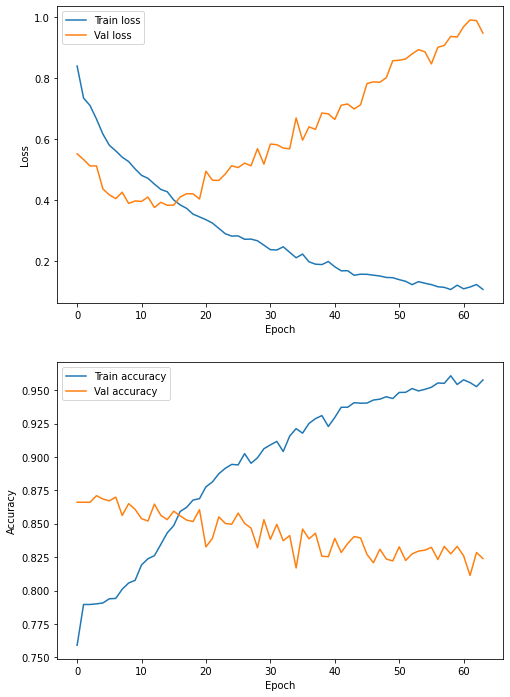

In [ ]:
# visualize history - trail1
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
            label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
            label='Train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val accuracy')
    plt.legend()
plot_history(cnn_history)

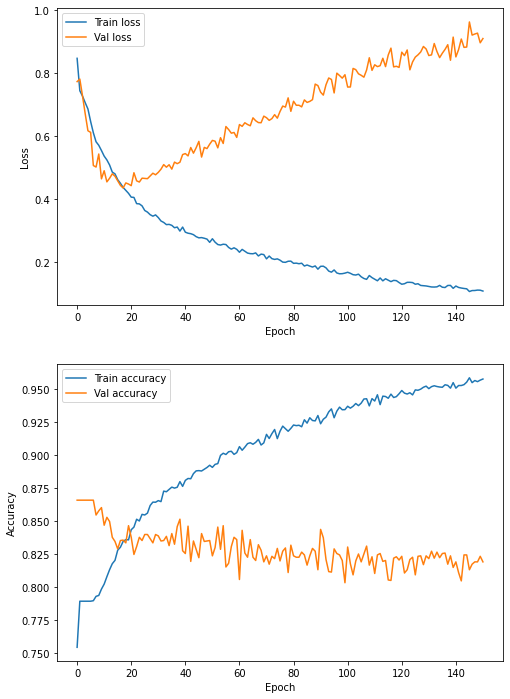

In [ ]:
# visualize history - trail2
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
            label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
            label='Train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val accuracy')
    plt.legend()
plot_history(cnn_history)

In [ ]:
# save model
# cnn.save("./models/3d_cnn2.h5")

# model load하는 경우
cnn  = tf.keras.models.load_model("./models/3d_cnn.h5")

- 정상(annotation img 값이 모두 0): 0
- metastasis: 1
- HCC: 2
- cholangiocarcinoma: 3
- 기타(데이터 충분하지 않음): 삭제된 데이터


In [ ]:
def output_class(x):
    output = np.argmax(x)
    if output == 0:
        return 'normal'
    elif output == 1:
        return 'metastasis'
    elif output == 2:
        return 'HCC'
    elif output == 3:
        return 'cholangiocarcinoma'
        
from sklearn.metrics import confusion_matrix
y_pred = cnn.predict(X_i_te)    
y_true=pd.DataFrame(Y_te_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)

In [ ]:
Y_te_cat.shape

(2845, 4)

In [ ]:
print(confusion_matrix(y_true, y_pred_classified))

from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classified))

[[   6   22   32   23]
 [  10    0   27   28]
 [  18   11   63  141]
 [  35   18  126 2285]]
                    precision    recall  f1-score   support

               HCC       0.09      0.07      0.08        83
cholangiocarcinoma       0.00      0.00      0.00        65
        metastasis       0.25      0.27      0.26       233
            normal       0.92      0.93      0.92      2464

          accuracy                           0.83      2845
         macro avg       0.32      0.32      0.32      2845
      weighted avg       0.82      0.83      0.82      2845



In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = cnn.predict(X_i_tr)    
y_true=pd.DataFrame(Y_tr_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)

print(confusion_matrix(y_true, y_pred_classified))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classified))

[[ 673    0    1   48]
 [   0  358    0    5]
 [   3    0  981  154]
 [   3   10   51 8275]]
                    precision    recall  f1-score   support

               HCC       0.99      0.93      0.96       722
cholangiocarcinoma       0.97      0.99      0.98       363
        metastasis       0.95      0.86      0.90      1138
            normal       0.98      0.99      0.98      8339

          accuracy                           0.97     10562
         macro avg       0.97      0.94      0.96     10562
      weighted avg       0.97      0.97      0.97     10562



#### trail 2 - confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix
y_pred = cnn.predict(X_i_te)    
y_true=pd.DataFrame(Y_te_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)

print(confusion_matrix(y_true, y_pred_classified))
print(classification_report(y_true, y_pred_classified))

[[   0   16   37   30]
 [  12    9   12   32]
 [  34   21   61  117]
 [  92   34   94 2244]]
                    precision    recall  f1-score   support

               HCC       0.00      0.00      0.00        83
cholangiocarcinoma       0.11      0.14      0.12        65
        metastasis       0.30      0.26      0.28       233
            normal       0.93      0.91      0.92      2464

          accuracy                           0.81      2845
         macro avg       0.33      0.33      0.33      2845
      weighted avg       0.83      0.81      0.82      2845



In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = cnn.predict(X_i_tr)    
y_true=pd.DataFrame(Y_tr_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)

print(confusion_matrix(y_true, y_pred_classified))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classified))

[[ 712    0    0   10]
 [   0  363    0    0]
 [   0    0 1108   30]
 [  33   14   80 8212]]
                    precision    recall  f1-score   support

               HCC       0.96      0.99      0.97       722
cholangiocarcinoma       0.96      1.00      0.98       363
        metastasis       0.93      0.97      0.95      1138
            normal       1.00      0.98      0.99      8339

          accuracy                           0.98     10562
         macro avg       0.96      0.99      0.97     10562
      weighted avg       0.98      0.98      0.98     10562

